# Stein-Variational Gradient Descent on Gaussian Mixtures

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import tensorflow as tf
import tensorflow_probability as tfp
import math

## Preparation
First we need an implementation of Gaussian Mixuture that also computes the derivative of its log-probability.

In [8]:
class GaussianMixture:
    def __init__(self, params):
        self.params = params

    def normalPdf(self, x, m, v):
        return tf.exp(-0.5 * (x - m)**2 / v**2) / (v * tf.sqrt(2 * tf.constant(math.pi, tf.float64)))

    def dnormalPdf(self, x, m, v):
        return self.normalPdf(x, m, v) * (-(x - m) / v**2)

    def pdf(self, x):
        return tf.reduce_sum([ c * self.normalPdf(x, m, v) for c, m, v in self.params], axis = 0)

    def dlnprob(self, x):
        return tf.reduce_sum([ c * self.dnormalPdf(x, m, v) for c, m, v in self.params], axis = 0) / self.pdf(x)

Then, we'll code a utility function to obtain density estimates from a Kernel Density Estimation:

In [9]:
def kernelDensityEstimation(x):
    kde = KernelDensity(kernel='gaussian').fit(x)
    return lambda y: np.exp(kde.score_samples(y.reshape(-1, 1)))

Now for the SVGD implementation. We use `tensorflow_cpu` to obtain accuracte gradients. The main struggle is to differentiate through the estimation of the bandwith $h = \dfrac{\text{med}^2}{\log(n)}$ for the gradient kernel matrix, where the median is obtained from pairwise differences. You can unfold the next cell 
to take a look at the implementation.

In [10]:
@tf.function
def precomputeUpperTriangularIndices(shape):
    """This very hacky function computes the indices of the upper triangular (without diagonal) of 
    a matrix given a shape.

    @shape: Shape of the matrix
    """
    allIndices = tf.where(tf.ones(shape, tf.dtypes.bool))
    upperTriangSubIndices = tf.where(tf.reduce_all(
        allIndices[:, :-1] < allIndices[:, 1:], axis=1))

    return tf.gather_nd(allIndices, upperTriangSubIndices)


@tf.function
def squareEuclideanNorm(x):
    """Compute the squared euclidean norm by doing the matrix product 
    ijk,kji->ij using einsum, which is a special form which scales to infinite dimensions.

    @x: Matrix that the norm should be applied to.
    """
    return tf.einsum('ijk,kji->ij', x, tf.transpose(x))


@tf.function
def selectKernelWidth(normedDistances, upperTriangularIndices):
    euclideanPwDistances = tf.sqrt(normedDistances)

    distances = tf.gather_nd(euclideanPwDistances, upperTriangularIndices)
    pwDistanceMedian = tfp.stats.percentile(
        distances, 50.0, interpolation='midpoint')

    return pwDistanceMedian**2 / tf.math.log(tf.cast(normedDistances.shape[0], tf.float64))


@tf.function
def pairwiseDistance(x):
    return tf.expand_dims(x, 1) - tf.expand_dims(x, 0)


@tf.function
def rbfkernel(x, precomputedUpperTriangularIndices):
    pwdist = pairwiseDistance(x)
    normedDist = squareEuclideanNorm(pwdist)
    h = selectKernelWidth(normedDist, precomputedUpperTriangularIndices)

    return tf.exp(-normedDist / h)


class SVGD:
    def __init__(self, x0, lr):
        """Costly precomputations done here - better know the shape of your problem!
        """
        self.x0 = x0
        self.opt = tf.keras.optimizers.Adam(lr)

        self.n = x0.shape[0]
        self.precomputedUpperTriangularIndices = precomputeUpperTriangularIndices(
            (self.n, self.n))

    def update(self, dlnprob, niter):

        x = tf.Variable(self.x0)

        for _ in range(niter):
            with tf.GradientTape() as tape:
                Kxy = rbfkernel(x, self.precomputedUpperTriangularIndices)
            kernelGrad = tape.gradient(Kxy, [x])[0]

            loggrad = dlnprob(x)

            # minus to cancel out the negative descent of AdaGrad
            completeGrad = -(1 / self.n) * (Kxy @ loggrad + kernelGrad)

            self.opt.apply_gradients([(completeGrad, x)])
        return x


## Approximating a Gaussian Mixture
We initialize the model with some samples from $\mathcal{N}(x | 10, 1)$ and also directly obtain a KDE-operator. Try to change the number of samples to see 
how it affects the result (see more below):

In [31]:
x0 = tf.random.normal((100, 1), -10,1, dtype=tf.float64)
kde0 = kernelDensityEstimation(x0.numpy())

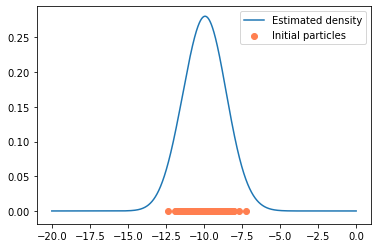

In [32]:
x = np.linspace(-20, 0, 10000)
plt.plot(x, kde0(x), label="Estimated density")
plt.scatter(x0, np.zeros(x0.shape), color="coral", label="Initial particles")
dummy = plt.legend()

Now we instantiate the Gaussian Mixture. For the mixture we use two components with distribution $\{\frac{1}{3}, \frac{2}{3}\}$ and Gaussians $\mathcal{N}(x | -2, 1)$ and $\mathcal{N}(x | 2, 1)$ respectively (just like in the paper):

In [33]:
gaussianMix = GaussianMixture([(1/3, -2, 1), (2/3, 2, 1)])

Let us take a look at the intial guess versus the target distribution $p(x)$:

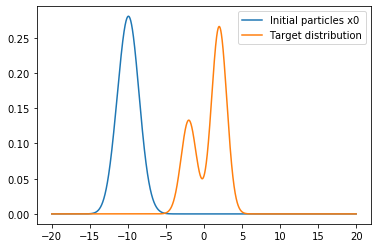

In [34]:
x = np.linspace(-20, 20, 10000)
plt.plot(x, kde0(x), label="Initial particles x0")
plt.plot(x, gaussianMix.pdf(x), label="Target distribution")
dummy = plt.legend()

Lastly, we randomly sample from a far off unimodal Gaussian and call `SVGD`. This implementation is not as fast as the one from the paper, maybe it is due to the use of `tensorflow` or there is another bottleneck. If you find it, open a PR or an issue and let me know! Note that the implementation can be applied to any dimension of data.

In [35]:
svgd = SVGD(x0, 0.8)
finalParticles = svgd.update(gaussianMix.dlnprob, 500)

We also estimate the density based on the samples, to have a nice visualization:

In [36]:
kdeFinalParticles = kernelDensityEstimation(finalParticles.numpy())

## Visualization
We compare the final estimates with the initial guess and the target distribution:

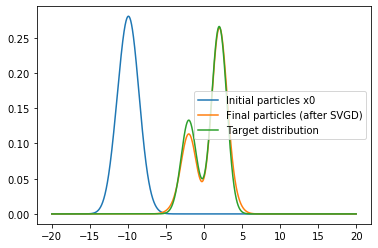

In [37]:
x = np.linspace(-20, 20, 10000)
plt.plot(x, kde0(x), label="Initial particles x0")
plt.plot(x, kdeFinalParticles(x), label="Final particles (after SVGD)")
plt.plot(x, gaussianMix.pdf(x), label="Target distribution")
dummy = plt.legend()